Obtaining city id: 深圳市success
地铁1号线
f19e82a86ef8036b33f71d6c 340
地铁1号线(罗宝线)(机场东-罗湖) success
d0d5edff85250abeb65f1e6c 340
地铁1号线(罗宝线)(罗湖-机场东) success


<AxesSubplot:>

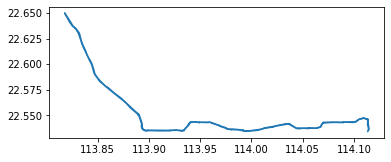

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import transbigdata as tbd

l,s = tbd.getbusdata('深圳市','地铁1号线')
l.plot()
s.plot()

In [4]:
import urllib
import json
def getlinegeo(uid,c):
    url = 'http://map.baidu.com/?qt=bsl&uid='+uid+'&c='+c
    response = urllib.request.urlopen(url,timeout = 60)
    searchinfo=json.loads(response.read().decode('utf8'))
    return searchinfo
data = getlinegeo('f19e82a86ef8036b33f71d6c','340')

In [9]:
data

{'anti_auth': 'v4KxSSwHzwKbxa=Ux9zTa7FcP7LKO0IOuxLELNVNLRHtBalTBnlcAZzvYgP1PcGCgYvjPuVtvYgPMGvgWv@uVtvYgPPxRYuVtcvY1SGpuHtA=k6dA=b0A96Gz8yvYgP@ZPcPPuVtvYgPhPPyheuxtwi04vy77uy1uVtCGYuVt1GgvPUDZYOYIZuVt1cv3uVtGccZcuVtPWv3GuVtPYIuVtPYIUvhgMZSguxzBEHLNRTVtcEWe1aDYyuVt@ZPuVtc3CuVteuVtegvcguxLELNVNLRHtimNNz8yrZZWuV',
 'content': [{'alias': ' ',
   'company': ' ',
   'endTime': '18:00',
   'end_index': 35,
   'geo': '2|12671583.86,2559651.74;12704607.82,2573480.56|12704537.43,2559714.66,12704564.86,2559958.74,12704607.82,2559971.04,12704537.27,2560171.50,12704487.46,2560468.56,12704521.49,2560559.85,12704512.44,2560696.54,12704474.44,2560685.56,12704518.82,2561004.12,12704516.94,2561081.17,12704470.04,2561107.21,12704445.26,2561086.54,12704481.91,2561084.31,12704405.99,2561111.74,12704310.48,2561162.71,12704258.33,2561221.06,12704205.08,2561178.98,12704135.99,2561218.75,12704104.47,2561273.71,12704072.50,2561225.74,12704022.50,2561260.25,12703994.00,2561217.24,12703900.49,2561251.74,12703572.